# Colorization Tensorflow Project using a Convolutional Neural Network
### By: Kyle Miller
This was a fun project once I was able to find some backgroundo n what CNN's do and how to implement one in Tensorflow.  You will find references throughout this notebook, but the resource that really helped was this: https://www.freecodecamp.org/news/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d/  While it was a guide for an older version of tensorflow, it was enough to point me in the right direction.  I ended up using a nearly identical alpha build of their CNN code.  The main difference was the image size and type that I used there.  I also did additional testing beyond what they described in their work.  Due to time constraints I have not pursued their beta build yet.<br>
The CNN I built and tested has 12 layers, 9 of which are convolutional and 3 of which are upscaling (to compensate for the downscaling that occurs when you use strides).  There were a total of 32,202 weights that were trained in this model.  Attached to this notebook you will find the images I trained and tested with, along with the weights for the model.  The most recent model is entited: 'trained_on_ten'<br>


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from IPython.display import Image

In [2]:
tf.__version__

'2.1.0'

Procedure:
1. Download bird dataset from: http://www.vision.caltech.edu/visipedia/CUB-200.html
2. convert images to b/w in lightroom (turns out I didn't need to do this step)
3. Crop images to a size that is divisible by 2.  i chose 512 x512 pixels since the originals were 500px on long side
4. Create the CNN and train on a single image for an increasing number of epochs, maxing at 3000
5. Test teh CNN with a number of images of similar birds
6. Retrain the CNN with an additional 10 images
7. Test the CNN on the same test set and see if there was improvement (there was ~10 fold decrease in error)

In [33]:
from PIL import Image

In [34]:
#get all files
#These files are from my home computer, but can be donwloaded from the link in the procedure
from os import listdir
from os.path import isfile, join
path = 'D:\\Kyle Work\\bird_portfolio'
color = f'{path}\\color_full'
bw = f'{path}\\bw_full'


color_files = [f for f in listdir(color) if isfile(join(color, f))]
bw_files = [f for f in listdir(bw) if isfile(join(bw, f))]

In [35]:
print(color_files[:5])
print(bw_files[:5] )

['Acadian_Flycatcher_0001_526757101.jpg', 'Acadian_Flycatcher_0002_2879202801.jpg', 'Acadian_Flycatcher_0003_xxx.jpg', 'Acadian_Flycatcher_0004_59204923.jpg', 'Acadian_Flycatcher_0005_156823596.jpg']
['Acadian_Flycatcher_0001_526757101_BW.jpg', 'Acadian_Flycatcher_0002_2879202801_BW.jpg', 'Acadian_Flycatcher_0003_xxx_BW.jpg', 'Acadian_Flycatcher_0004_59204923_BW.jpg', 'Acadian_Flycatcher_0005_156823596_BW.jpg']


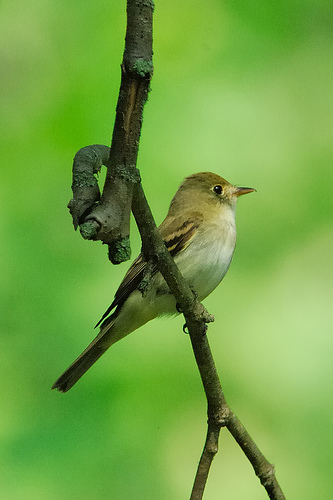

In [36]:
im_c = Image.open(f'{color}\\{color_files[0]}')
im_c

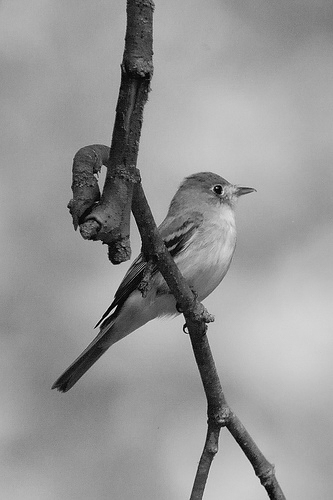

In [37]:
im = Image.open(f'{bw}\\{bw_files[0]}')
im

## Resize all files to square size
Only run this once...

In [38]:
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result
    
def newWidth(pil_img, background_color=(0,0,0), new_width=512):
    width,height = pil_img.size
    result = Image.new(pil_img.mode, (new_width, new_width), background_color)
    result.paste(pil_img, ((new_width - width) // 2, (new_width-height) // 2))
    return result

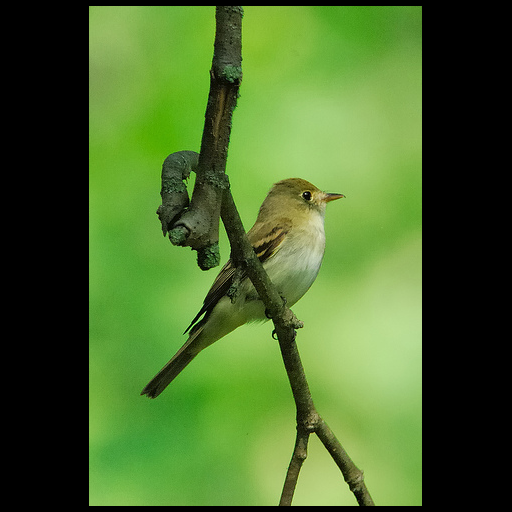

In [39]:
newWidth(im_c)

In [41]:
"""
for image in color_files:
    im = Image.open(f'{color}\\{image}')
    im_new = expand2square(im, (0, 0, 0))
    im_new.save(f'{color}\\square\\{image}')
for image in bw_files:
    im = Image.open(f'{bw}\\{image}')
    im_new = expand2square(im, (0, 0, 0))
    im_new.save(f'{bw}\\square\\{image}')
    

for image in color_files:
    im = Image.open(f'{color}\\{image}')
    im_new = newWidth(im, (0, 0, 0))
    im_new.save(f'{color}\\square512\\{image}')
for image in bw_files:
    im = Image.open(f'{bw}\\{image}')
    im_new = newWidth(im, (0, 0, 0))
    im_new.save(f'{bw}\\square512\\{image}')
"""

In [42]:
color = f'{color}\\square512'
bw = f'{bw}\\square512'

(512, 512)


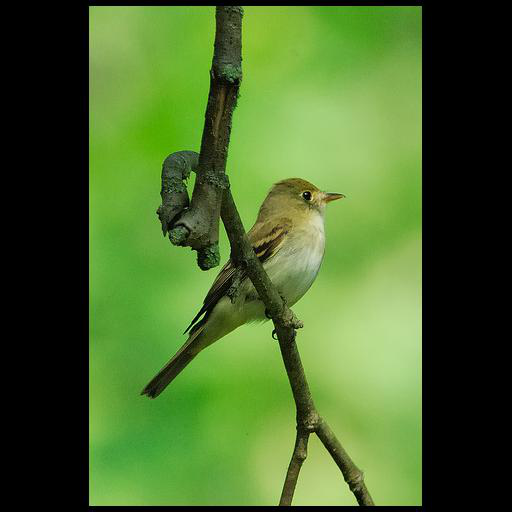

In [43]:
image_color = Image.open(f'{color}\\{color_files[0]}')
print(image_color.size)
image_color

(512, 512)


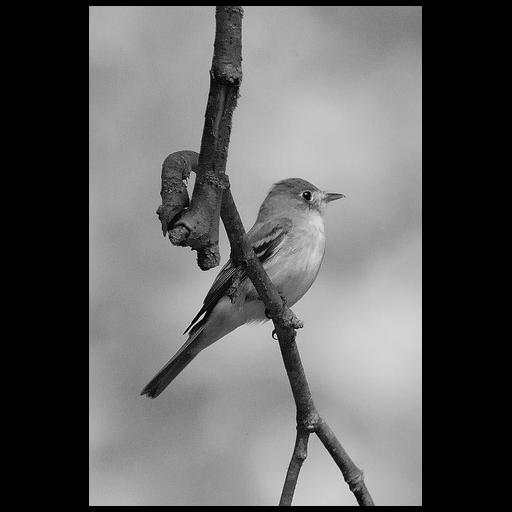

In [44]:
image_bw = Image.open(f'{bw}\\{bw_files[0]}')
print(image_bw.size)
image_bw

In [45]:
#api for getting the pixel values
list(image_bw.getdata())[100:110]

[(0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (0, 0, 0),
 (1, 1, 1),
 (1, 1, 1),
 (1, 1, 1),
 (1, 1, 1),
 (1, 1, 1),
 (1, 1, 1)]

# Start building the Neural Network
I am referencing the guide found here: https://www.freecodecamp.org/news/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d/

In [46]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

In [47]:
color_array = img_to_array(image_color)
print(color_array.shape)
print(type(color_array))

(512, 512, 3)
<class 'numpy.ndarray'>


In [48]:
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave

In [49]:
#extract the luminance channel of the image
X = rgb2lab(1.0/255*color_array)[:,:,0]
#extract the a/b channels of the LAB image
y = rgb2lab(1.0/255*color_array)[:,:,1:]
y /= 128

#the image is 500x500 pixels, reshape the arrays
X = X.reshape(1, 512, 512, 1)
y = y.reshape(1, 512, 512, 2)

## Model Graph:
Strides are basically downsampling, skipping lines as the filter is applied
6 layers of filtering, 3 of which downsmaple the image, followed by three more layers that filter and subsequently upsample.  The filter (kernel) size stays constant with a 3x3 window with a varying number of filters 8,16,32.  I am not certain why these choices were made unfortunately.  I am following the exampel from above and updating code from here: https://www.floydhub.com/emilwallner/projects/color/43/code/Alpha-version/alpha_version.ipynb
<br>
Documentation for these types of layers: https://www.tensorflow.org/api_docs/python/tf/keras/layers

In [51]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(name='input', input_shape=(512,512,1)),
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(2, (3, 3), activation='tanh', padding='same'),
    ])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 256, 256, 8)       80        
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 256, 256, 8)       584       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 256, 256, 16)      1168      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
up_sampling2d_12 (UpSampling (None, 128, 128, 32)     

In [54]:
# Finish model
model.compile(optimizer='rmsprop', loss='mse')

## Train the model on a single image
uncomment to rerun the training, or if the training has already been run, load the model

In [66]:
epochs=3000
#model.fit(x=X, y=y, batch_size=1, epochs=epochs, verbose=0)
#model.save_weights(f'singleImage{epochs}')

## Load the model if it already exists

In [ ]:
#model.load_weights(f'singleImage{epochs}')

## Test the model on the same image

In [67]:
print(model.evaluate(X, y, batch_size=1))
output = model.predict(X)
output *= 128
# Output colorizations
cur = np.zeros((512, 512, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0]
imsave("img_result_3000.png", lab2rgb(cur))
#imsave("img_gray_version.png", rgb2gray(lab2rgb(cur)))

1/1 [==============================] - 0s 41ms/sample - loss: 1.1884e-04


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.0001188358583021909


## Results and progression of the model training

Black and White Original:


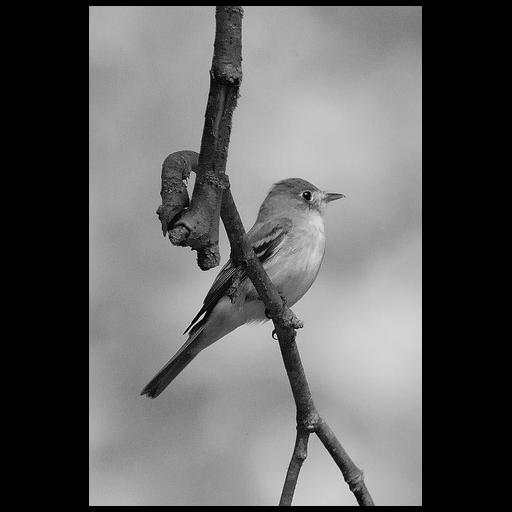

Epochs of Training: 1


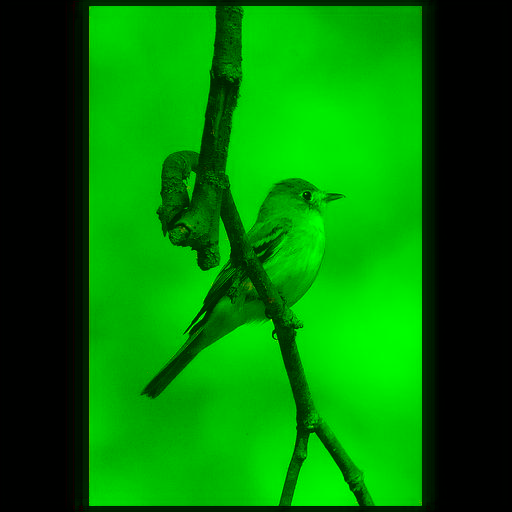

Epochs of Training: 10


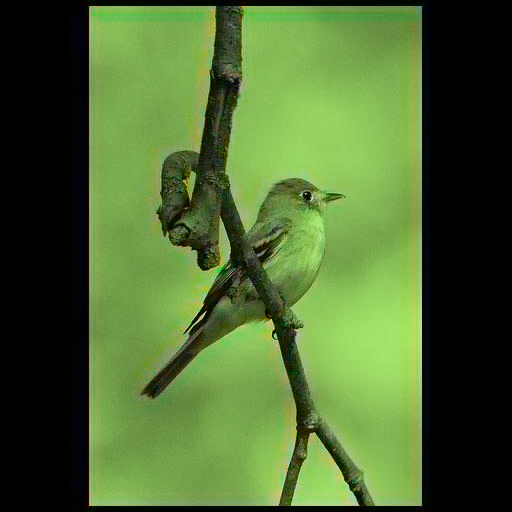

Epochs of Training: 100


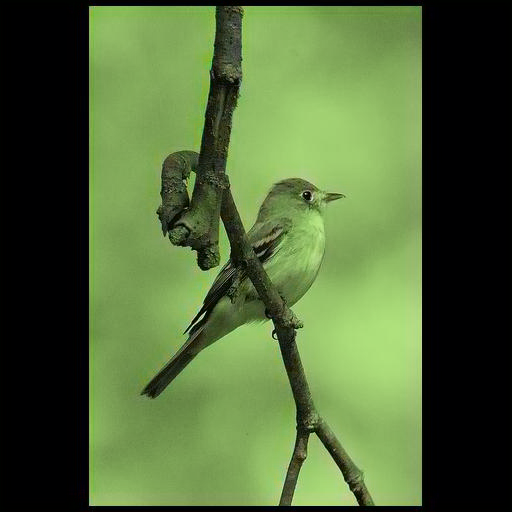

Epochs of Training: 500


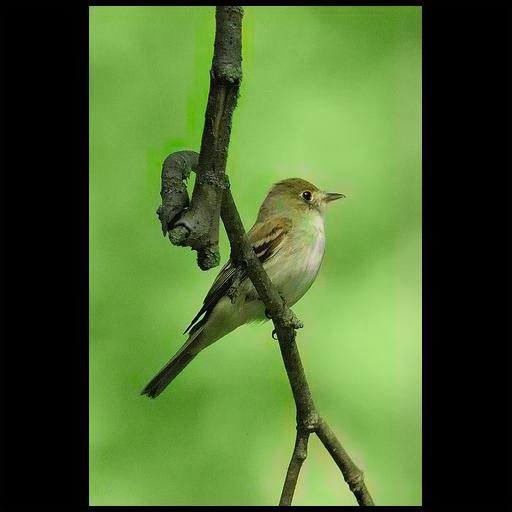

Epochs of Training: 1000


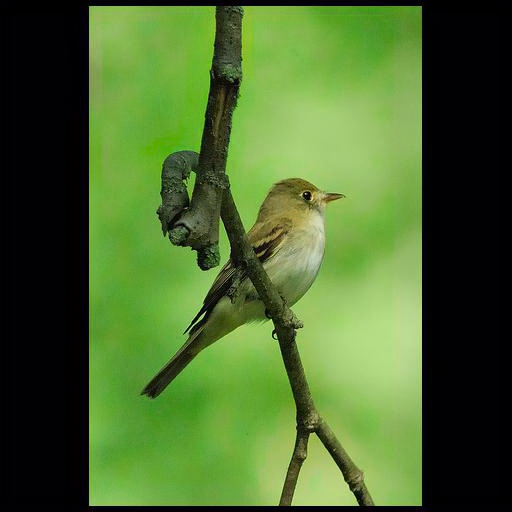

Epochs of Training: 3000


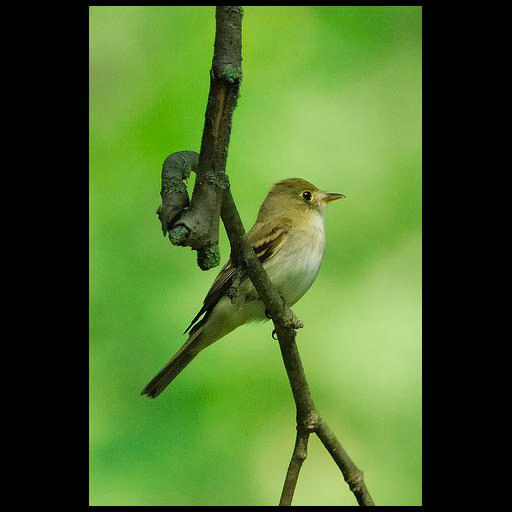

Original Color:


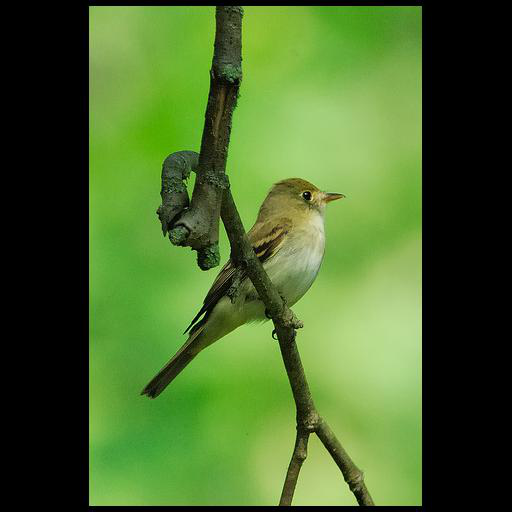

In [76]:
epoch_tests = [1,10,100,500,1000,3000]
print("Black and White Original:")
display(Image.open(f'images\\SingleImageTraining\\original_bw.jpg'))
for epoch in epoch_tests:
    im = Image.open(f'images\\SingleImageTraining\\img_result_{epoch}.png')
    print(f'Epochs of Training: {epoch}')
    display(im)
print("Original Color:")
display(Image.open(f'images\\singleImageTraining\\original_color.jpg'))

## Now test it on unseen samples of the same bird

In [79]:
def get_Xy_from_color_array(colorArray):
    """
    Parameter: array of color image with dimensions 512x512
    Return: X value with luminance channel and y value with a/b channels"""
    #extract the luminance channel of the image
    X = rgb2lab(1.0/255*color_array)[:,:,0]
    #extract the a/b channels of the LAB image
    y = rgb2lab(1.0/255*color_array)[:,:,1:]
    y /= 128
    
    #the image is 500x500 pixels, reshape the arrays
    X = X.reshape(1, 512, 512, 1)
    y = y.reshape(1, 512, 512, 2)
    
    return X,y
    


In [98]:
# get images
path = 'images\\Testing'
species = '\\Acadian_Flycatcher'
folder = '\\original'
path_complete = path+species+folder
print(path_complete)
files = [f for f in listdir(path_complete) if isfile(join(path_complete, f))]

images\Testing\Acadian_Flycatcher\original


In [ ]:
scores={}
for file in files:
    color_array = img_to_array(Image.open(f'{path+species+folder}\\{file}'))
    X,y = get_Xy_from_color_array(color_array)
    
    scores[file] = model.evaluate(X, y, batch_size=1)
    output = model.predict(X)
    output *= 128
    # Output colorizations
    cur = np.zeros((512, 512, 3))
    cur[:,:,0] = X[0][:,:,0]
    cur[:,:,1:] = output[0]
    imsave(f"images\\Testing\\Acadian_Flycatcher\\colorized\\new{file}", lab2rgb(cur))



In [97]:
#save log file of scores
f = open("images\\Testing\\Acadian_Flycatcher\\colorized\\scores.txt","w")
for key,value in scores.items():
    f.write(f'{key}: {value}\n')
f.close()

## Results on new data
Not great, but that is to be expected since the model was only trained on a single image.  Below is an example of an image that had the least amount of loss (0.013) which is still 100x worse than the model performed on the image it trained on

In [107]:
image = files[7]
image_data = []
image_data.append(Image.open(path_complete+'\\'+image))
image_data.append(Image.open(path+species+'\\colorized\\new'+image))

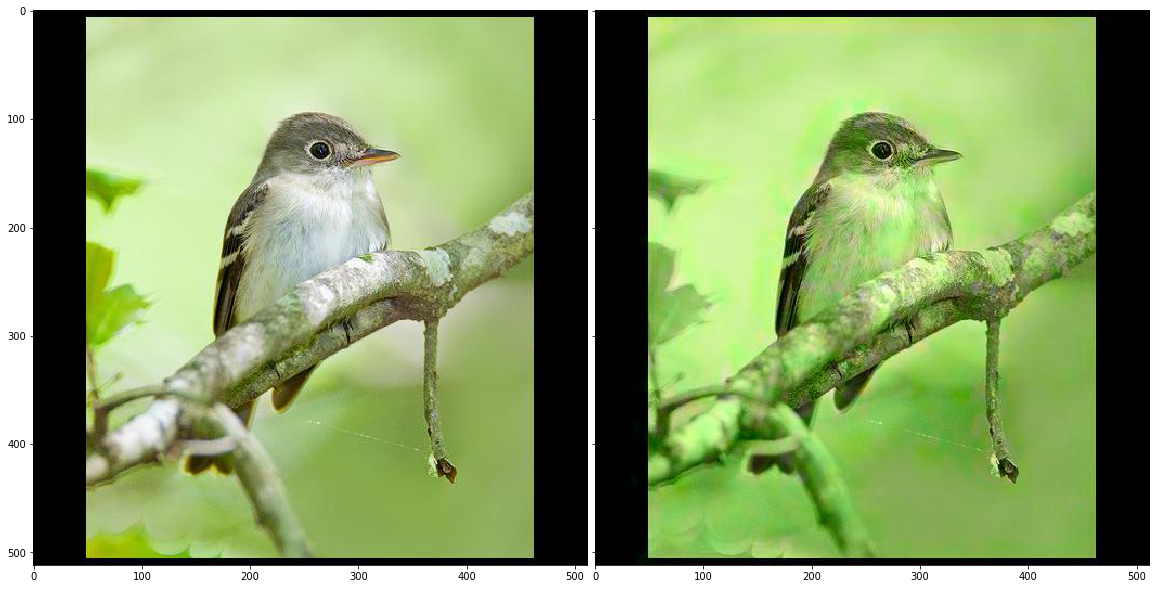

In [113]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1, 2),  
                 axes_pad=0.1,  
                 )

for ax, im in zip(grid, image_data):
    ax.imshow(im)

plt.show()

## Retrain the model with more sample images
For the sake of simplicity I am just going to do 10 more images through the fit api for 1000 epochs each

In [ ]:
epochs = 100
for i in range(10):
    for file in files[:10]:
        color_array = img_to_array(Image.open(f'{path+species+folder}\\{file}'))
        X,y = get_Xy_from_color_array(color_array)
        model.fit(x=X, y=y, batch_size=1, epochs=epochs, verbose=0)
    for file in files[:10]:
        color_array = img_to_array(Image.open(f'{path+species+folder}\\{file}'))
        X,y = get_Xy_from_color_array(color_array)
        output = model.predict(X)
        output *= 128
        # Output colorizations
        cur = np.zeros((512, 512, 3))
        cur[:,:,0] = X[0][:,:,0]
        cur[:,:,1:] = output[0]
        imsave(f"images\\{i}_{file}", lab2rgb(cur))

In [ ]:
scores={}
for file in files:
    color_array = img_to_array(Image.open(f'{path+species+folder}\\{file}'))
    X,y = get_Xy_from_color_array(color_array)
    
    scores[file] = model.evaluate(X, y, batch_size=1)
    output = model.predict(X)
    output *= 128
    # Output colorizations
    cur = np.zeros((512, 512, 3))
    cur[:,:,0] = X[0][:,:,0]
    cur[:,:,1:] = output[0]
    imsave(f"images\\Testing\\Acadian_Flycatcher\\colorized\\new2_{file}", lab2rgb(cur))

In [118]:
f = open("images\\Testing\\Acadian_Flycatcher\\colorized\\scores.txt","w")
for key,value in scores.items():
    f.write(f'{key}: {value}\n')
f.close()

The scores have improved overall by about 10 fold, naturally one of the images used in the training has improved

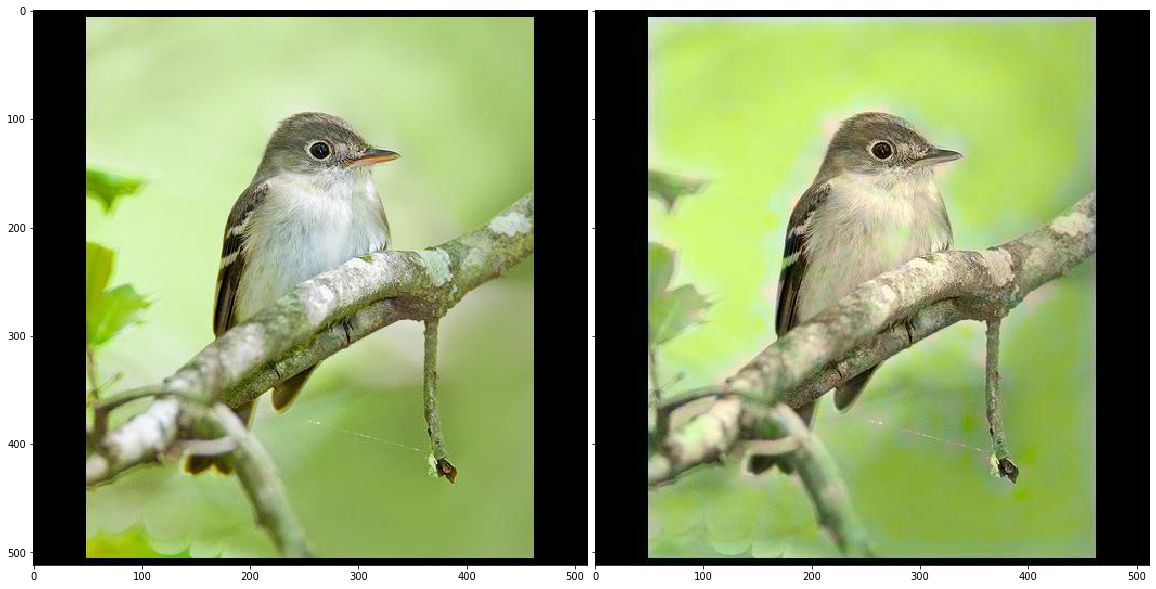

In [119]:
image = files[7]
image_data = []
image_data.append(Image.open(path_complete+'\\'+image))
image_data.append(Image.open(path+species+'\\colorized\\new2_'+image))

fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1, 2),  
                 axes_pad=0.1,  
                 )

for ax, im in zip(grid, image_data):
    ax.imshow(im)

plt.show()

## Results from test images that were not trained on
Originals on the left, colorizations on the right

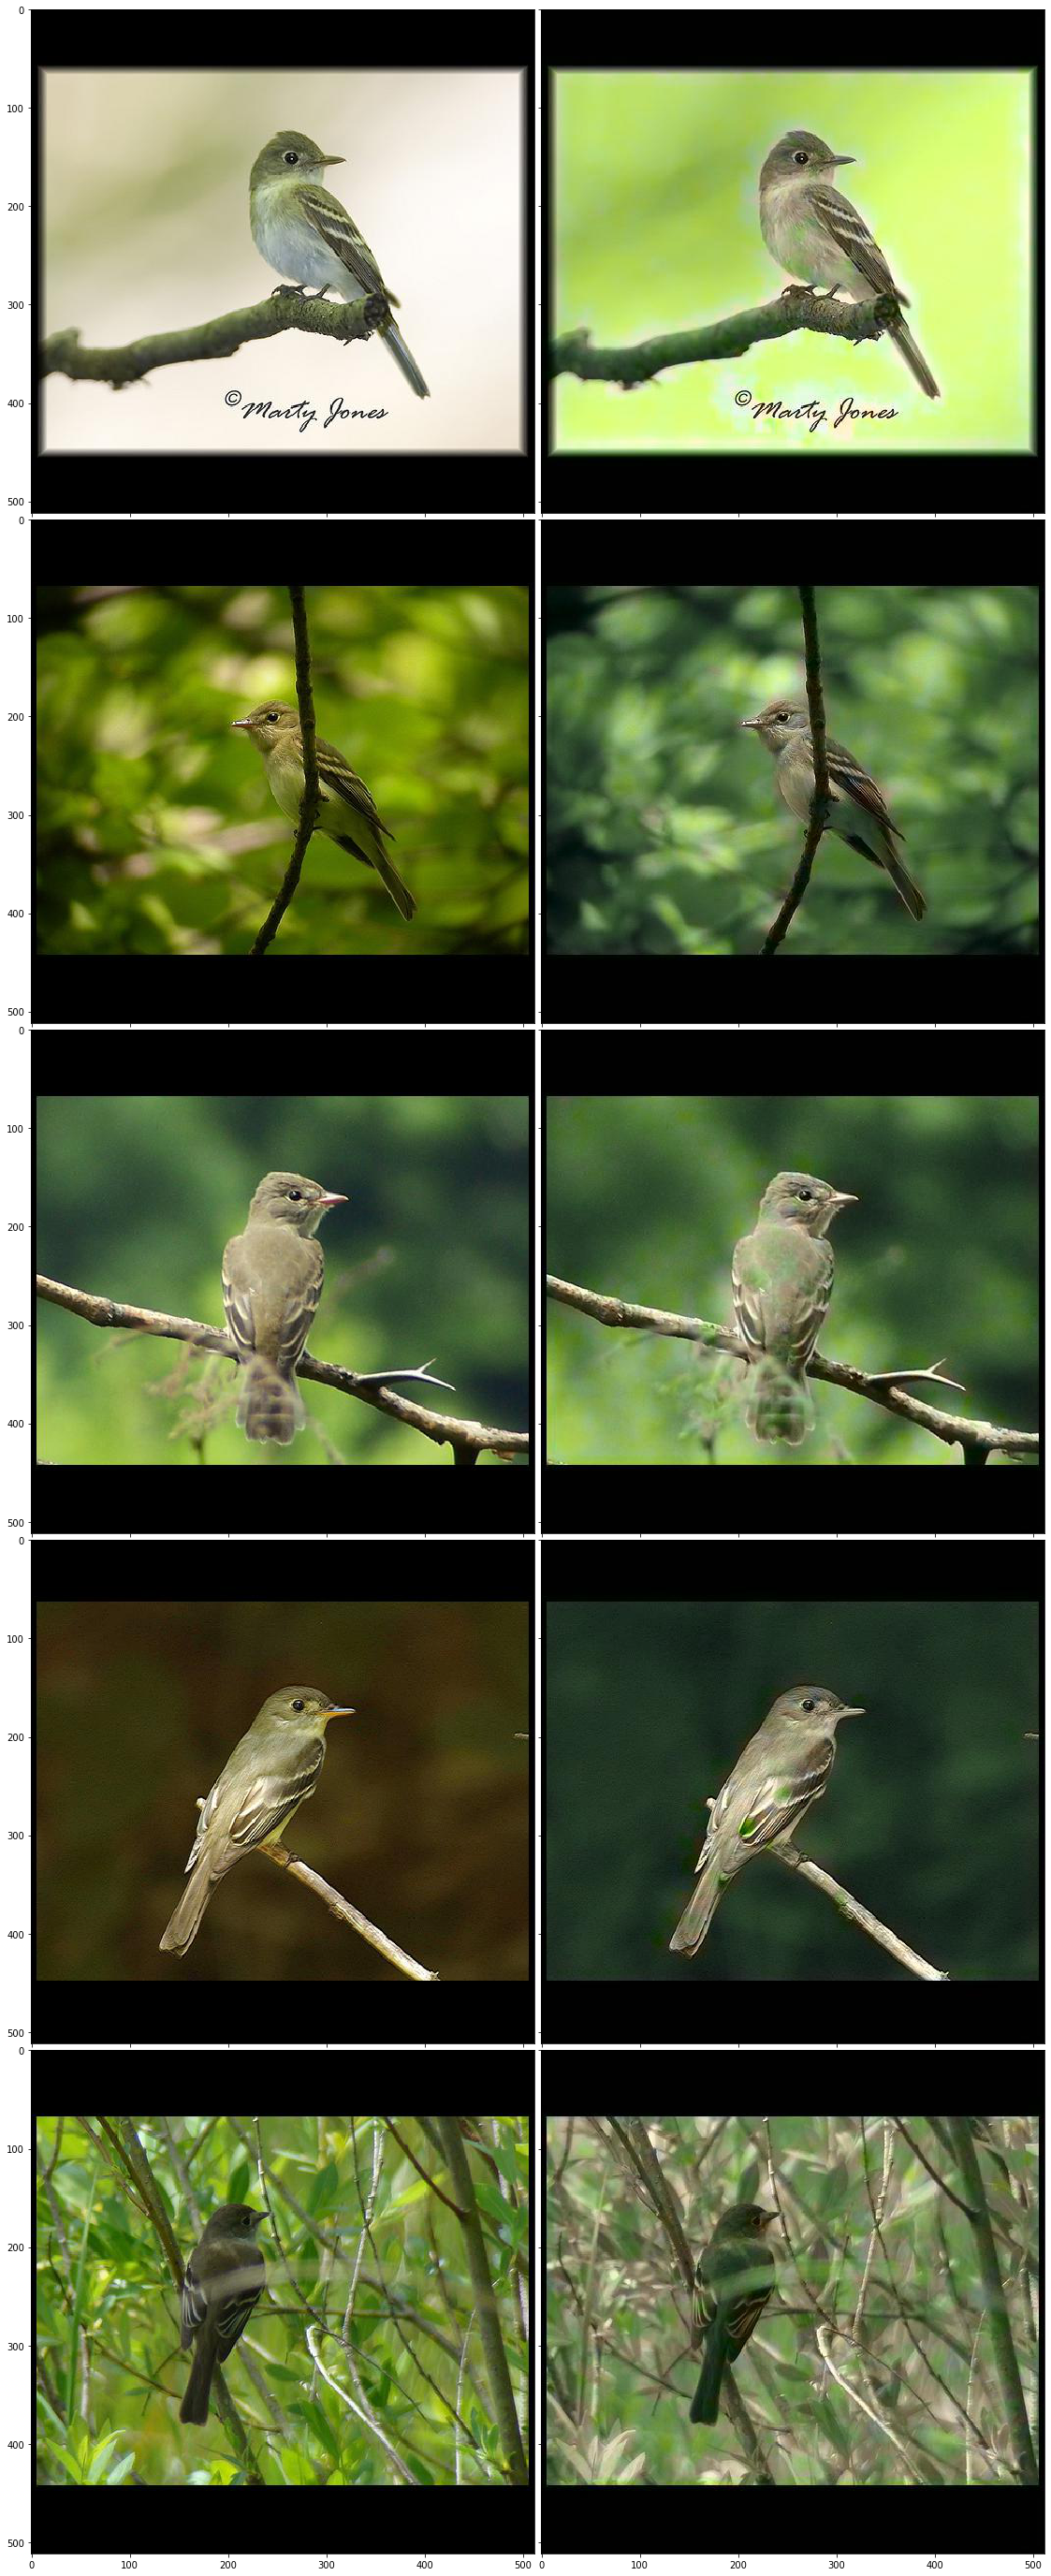

In [127]:
image_data = []
for file in files[12:17]:    
    image_data.append(Image.open(path_complete+'\\'+file))
    image_data.append(Image.open(path+species+'\\colorized\\new2_'+file))

fig = plt.figure(figsize=(50, 50))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(5, 2),  
                 axes_pad=0.1,  
                 )

for ax, im in zip(grid, image_data):
    ax.imshow(im)
plt.savefig('testResults.png')
plt.show()

In [128]:
model.save_weights('trained_on_ten')